Pour ce TP, vous aurez besoin des modules suivants:

(Adaptez la commande à votre système)

In [1]:
! pip3 install numpy matplotlib tqdm arcade==2.6.17 spg==0.1.9 

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import pickle as pk
from tqdm import tqdm

## TP2: Rétropropagation

L'objectif de ce TP est d'implémenter à la main l'algorithme de rétropropagation du gradient, et de l'appliquer pour entraîner un perceptron multi-couche à imiter une politique consistant à longer les murs dans un environnement 2D.

Dans la première partie, nous allons nous concentrer sur l'implémentation de l'algorithme de rétropropagation, et dans une deuxième partie nous l'appliquerons à la tâche d'apprentissage mentionnée.

### 1. Rétropropagation du gradient

Le code à compléter vous est fourni dans ce notebook, il n'y aura pas besoin d'aller toucher aux autres fichiers.

Dans cette première cellule, on définit une classe abstraite `Node`, correspondant à un noeud quelconque dans un graphe de calcul. 
La classe `Node` est équipée de deux attributs:
- `parameters`: un dictionnaire donnant les valeurs actuelles des paramètres du noeud
- `gradients`: un dictionnaire donnant les valeurs actuelles des gradients calculés sur les paramètres du noeud, avant qu'ils ne soient appliqués

La classe `Node` est également équipée de quatre méthodes:
- `forward`: permet de calculer la sortie du noeud en fonction des entrées
- `backward`: permet de calculer le gradient par rapport aux différentes entrées, en fonction du gradient par rapport à la sortie
- `zero_grad`: permet de remettre à 0 tous les gradients accumulés par l'appel de la méthode `backward`
- `step`: permet de réaliser une étape de descente de gradient sur les paramètres du noeud, en suivant la règle d'apprentissage vue en cours


#### Question 1.
Complétez la définition de la méthode `step`. Le paramètre `lr` donné en argument veut dire "learning rate", et correspond au lambda dans l'équation vue en cours. La méthode doit mettre à toujours tous les paramètres qui sont listés dans le dictionnaire, en appliquant la règle de descente de gradient. Les gradients sont censés être calculés par la méthode `backward` dont l'implémentation dépendra du noeud (la classe est pour l'instant abstraite, on verra ça ensuite). On suppose donc ici que les valeurs des gradients sont déjà calculées et disponibles dans le dictionnaire `self.gradients`.

In [3]:
class Node(ABC):

    def __init__(self):
        self.parameters = {}
        self.gradients = {}

    @abstractmethod
    def forward(*args):
        # Calcule la sortie du noeud en fonction des entrées
        pass

    @abstractmethod
    def backward(self, dy):
        # Calcule les gradients des paramètres en fonction de dy
        pass

    def zero_grad(self):
        # Remet à zéro les gradients
        for key in self.gradients:
            self.gradients[key] = 0

    def step(self, lr):
        for key, value in self.parameters.items():
            self.parameters[key] -= lr * self.gradients[key]

#### Question 2.

Nous allons maintenant définir le premier noeud de notre perceptron multi-couche. Pour commencer, on va s'intéresser au noeud correspondant à la fonction d'activation tanh. Ce noeud ne possède pas de paramètres, et donc il suffira d'implémenter les méthodes `forward` et `backward`.

Le noeud doit pouvoir prendre des entrées vectorielles (et même des np.array à deux dimensions, nous verrons ça plus tard), il faut donc utiliser le module numpy plutôt que math.

On pourra remarquer qu'on a besoin de la valeur de tanh(x) dans le calcul du gradient. Pour résoudre ce problème, on peut conserver la valeur calculée pendant la passe `forward` dans un attribut (par exemple nommé `tanh_x`).

Complétez et tester la classe suivante:

In [4]:
class Tanh(Node):

    def forward(self, x):
        self.tanh_x = np.tanh(x)
        return self.tanh_x

    def backward(self, dy):
        return dy*(1 - np.pow(self.tanh_x, 2)) # tanh' = 1 - tanh^2

In [5]:
# Pour tester votre classe, vous pouvez utiliser le code suivant
tanh = Tanh()
x = np.array([-1, 1, 3])
y = tanh.forward(x)
print(y)  # Doit afficher [-0.76159416  0.76159416  0.99505475]

dy = np.array([-1, 1, 3])
dy = tanh.backward(dy)
print(dy)  # Doit afficher [-0.41997434  0.41997434  0.02959811]

[-0.76159416  0.76159416  0.99505475]
[-0.41997434  0.41997434  0.02959811]


#### Question 3.

Nous allons maintenant implémenter le noeud `Linear` qui possède lui des paramètres. Ce noeud effectue une transformation linéaire sur une entrée vectorielle: y = Wx + b.

Le constructeur prend en argument deux paramètres `n_in` et `n_out` donnant la dimension de l'entrée (x) et la dimension de la sortie (y). Comme en réalité on voudra manipuler des batchs d'entrées, `x` sera une matrice de taille (`batch_size`, `n_in`) et `y` sera une matrice de taille (`batch_size`,`n_out`)

Les paramètres à ajouter au dictionnaire sont:
- 'weights' contient une matrice de poids de taille (n_out x n_in)
- 'bias' contient un vecteur de biais de taille (n_out)

Les valeurs des paramètres sont initialisées aléatoirement suivant une distribution normale, obtenue en utilisant numpy.random.randn. Les gradients sont quant à eux initialisés à 0.

Complétez et tester la classe suivante:

In [6]:

class Linear(Node):

    def __init__(self, n_in, n_out):
        super().__init__()
        self.parameters['W'] = np.random.randn(n_out, n_in)
        self.parameters['b'] = np.random.randn(n_out)
        self.zero_grad()

    def forward(self, x):
        self.x = x
        return x @ self.parameters['W'].T + self.parameters['b'] 
        # @ is short for np.matmul
        # W needs to be transposed for dimensionnal coherence: x @ W.T is (n_batch, n_in) @ (n_in, n_out)

    def backward(self, dy):
        dx = dy @ self.parameters['W']
        self.gradients['W'] = dy.T @ self.x
        self.gradients['b'] = dy.sum(axis=0)
        return dx

In [7]:
# Pour tester votre classe, vous pouvez utiliser le code suivant
linear = Linear(3, 2)
x = np.array([[-1, 1, 3]])
y = linear.forward(x)
print(y.shape)  # Doit afficher (1, 2)

dy = np.array([[-1, 1]])
dy = linear.backward(dy)
print(dy.shape)  # Doit afficher (1, 3)

(1, 2)
(1, 3)


#### Question 4.

Nous allons maintenant implémenter le dernier noeud dont nous aurons besoin: celui qui réalise la fonction de perte. Dans ce TP, nous allons utiliser comme fonction de perte la Mean Squared Error (souvent abrégée MSE), une fonction de perte très classique utilisée dans les tâches de régression.

Cette fonction de perte prend deux entrées:
- Un vecteur `y_true` provenant du dataset, correspondant à la vraie valeur de sortie désirée du réseau de neurones
- Un vecteur `y_pred` produite par le réseau de neurones, que l'on souhaite faire tendre vers `y_true`

En réalité encore, comme on va manipuler des batchs, `y_true` et `y_pred` seront en réalité des matrices.

La sortie de la fonction de perte est la moyenne de ((`y_true` - `y_pred`) au carré). On peut comprendre intuitivement que cette fonction mesure une sorte de distance Euclidienne entre les deux vecteurs, et donc qu'en la minimisant, on encourage la sortie du réseau de neurones à être égale à la sortie désirée donnée dans le dataset.

Lors de la rétropropagation, on ne s'intéresse qu'au gradient par rapport à `y_pred` (c'est de ce côté du graphe de calcul qu'il y a des paramètres à optimiser). On ne renverra donc qu'une valeur.

Complétez et testez la classe suivante:

In [8]:
class MSELoss(Node):
    def forward(self, y_true, y_pred):
        self.N = y_pred.shape[0]
        self.error = y_pred - y_true
        return np.mean(np.pow(self.error,2), axis=1, keepdims=True)

    def backward(self, dy):
        return dy * (2 / self.N) * self.error
  

In [9]:
# Code pour tester votre classe
loss = MSELoss()
y_true = np.array([[-1, 1]])
y_pred = np.array([[-1, 2]])
y = loss.forward(y_true, y_pred)
print(y)  # Doit afficher 0.5

dy = np.array([1])
dy = loss.backward(dy)
print(dy)  # Doit afficher [[0. 2.]]

[[0.5]]
[[0. 2.]]


#### Question 5.

Pour finir cette partie, nous allons maintenant implémenter le graphe de calcul complet pour un perceptron multi-couches avec une couche cachée.

Le graphe doit être composé dans l'ordre:
- Un noeud Linear
- Un noeud Tanh
- Un deuxième noeud Linear (attention, différent du premier, avec ses propres paramètres)
- Un noeud Tanh
- Un noeud MSELoss

Tous ces noeuds doivent être enregistrés comme des attributs du réseau. La méthode `forward` prend deux entrées, `x` et `y_true`. En sortie, on doit obtenir le résultat de l'application de la fonction de perte sur `y_pred` et `y_true`, où `y_pred` correspond à la sortie du graphe en amont, obtenue en appelant les méthodes `forward` des différents noeuds.

Pour pouvoir réutiliser les réseaux de neurones en mode prédiction plus tard, on encapsulera toute la passe forward à l'exception de la fonction de perte dans une méthode `predict`.

La méthode `backward` doit à l'inverse appeler les méthodes `backward` des différents noeuds. A l'extrémité du graphe, on considère que `dy` vaut 1 (c'est le gradient de la sortie par rapport à elle même).

Les méthodes `zero_grad` et `step` doivent appeler les méthodes du même nom pour les noeuds concernés (ceux qui ont des paramètres).

Le constructeur de la classe prend en entrée:
- `n_in`: la dimension des entrées du réseaux de neurones
- `n_hidden`: la dimension de la couche cachée
- `n_out`: la dimension de la sortie
- `loss_fn`: l'instance de MSELoss que nous allons utiliser comme fonction de perte. Cette implémentation nous laisse la liberté de changer la fonction de perte sans modifier la classe.

Implémentez et testez la classe suivante:

In [10]:
class MultiLayerPerceptron:

    def __init__(self, n_in, n_hidden, n_out, loss_fn):
        self.graph = []
        self.graph.append(Linear(n_in, n_hidden))
        self.graph.append(Tanh())
        self.graph.append(Linear(n_hidden, n_out))
        self.graph.append(Tanh())
        self.graph.append(loss_fn)

    def forward(self, x, y_true):
        for n in self.graph[:-1]:
            x = n.forward(x)
        return self.graph[-1].forward(y_true, x)

    def backward(self, dy=1):
        for node in reversed(self.graph):
            dy = node.backward(dy)
        return dy 

    def predict(self, x):
        for node in self.graph[:-1]:
            x = node.forward(x)
        return x
            
    def zero_grad(self):
        for node in self.graph:
            node.zero_grad()

    def step(self, lr):
        for node in self.graph[:-1]:
            node.step(lr)

In [11]:
# Pour tester votre classe, vous pouvez utiliser le code suivant
n_in = 32
n_hidden = 100
n_out = 1

model = MultiLayerPerceptron(
    n_in,
    n_hidden,
    n_out,
    MSELoss()
)

# Fausses données juste pour le test
x = np.random.randn(100, n_in)
y_true = np.random.randn(100, n_out)

y = model.forward(x, y_true)
print(y.shape)  # Doit afficher (100, 1)

dy = model.backward()
print(dy.shape)  # Doit afficher (100, 32)

# Vous pouvez aussi tester la méthode step et vérifier qu'elle met bien à jour les paramètres des noeuds Linear

(100, 1)
(100, 32)


### Partie 2: Entraînement du modèle

Dans cette partie, nous allons voir comment entraîner le réseau que nous avons implémenté sur une tâche d'apprentissage par imitation.

L'environnement utilisé pour cette tâche est implémenté avec le module simple-playground (spg) que vous avez installé au début du notebook. Le fichier "env.py" contient le code nécessaire pour tester votre politique dans cet environnement. 

Simple playgrounds est un simulateur 2D. L'environnement choisi contient 9 pièces organisées en une grille de (3x3). L'agent est équipé d'un capteur de distance avec un champ de vision de 360° et une résolution de 32. L'état sensoriel de l'agent à un instant $t$ est donc un vecteur de dimension 32 indiquant pour chaque indice la distance du mur le plus proche dans la direction correspondante.

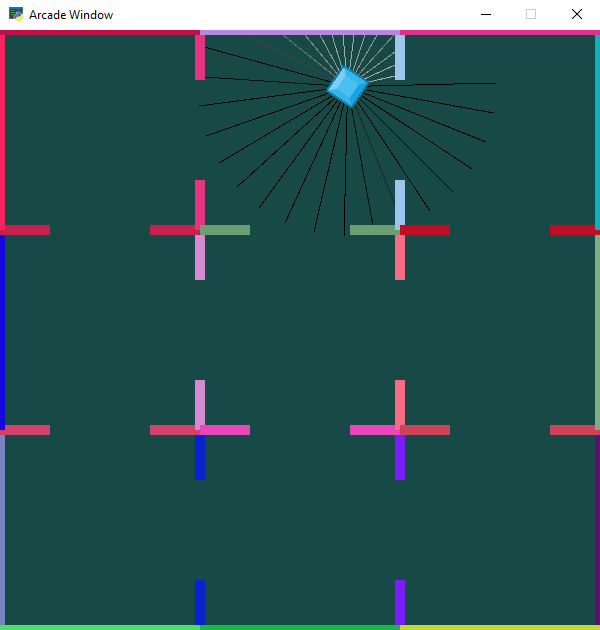

Nous avons au préalable récolté dans cet environnement 10 trajectoires suivant une politique consistant à longer le mur se situant à droite de l'agent.

Dans le dossier "data" se trouvent deux fichiers:
- sensory_states_wall.pk
- actions_wall.pk
contenant respectivement les trajectoires d'états sensoriels $s_t$ et des actions correspondantes $a_t$.

L'action correspond dans notre cas juste à la direction de rotation de l'agent à chaque instant $t$. $a_t = -1$ quand l'agent tourne vers la gauche, $a_t=0$ quand l'agent continue tout droit, et $a_t=1$ quand l'agent tourne vers la droite.

Comme nous souhaitons entraîner une politique permettant de calculer $a_t$ à partir de $s_t$, $s_t$ sera l'entrée du réseau `x`, et $a_t$ sera sa sortie désirée `y_true`.

Le bloc de code suivant sert à charger le dataset:

In [12]:
x = pk.load(open('data/sensory_states_wall.pk', 'rb'))
x = np.concatenate([np.array(traj).reshape(-1, 32) for traj in x], axis=0)
x = x.reshape(-1, 32)

y = pk.load(open('data/actions_wall.pk', 'rb'))
y = np.concatenate([np.array(traj).reshape(-1, 2)
                   for traj in y], axis=0)[:, 0:1] * 5

Les paires $(s_t, a_t)$ du dataset sont ordonnées dans l'ordre dans lequel elles ont été récolté. Cela peut être néfaste à l'apprentissage, car chaque batch risque de contenir des données très similaires. Il est toujours préférable de mélanger le dataset avant d'entraîner le réseau de neurones. C'est ce qui est réalisé dans la cellule suivante:

In [13]:
# Mélange aléatoire
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

#### Question 6:

Enfin, il faut séparer le dataset en deux: un dataset d'entraînement et un dataset de test. Le dataset d'entraînement contient les paires (x, y) qui seront utilisées pour l'entraînement du réseau de neurones. Le dataset de test contient les paires (x, y) restantes, qu'on utilise pour vérifier que le réseau de neurones n'est pas en situation d'overfitting (surapprentissage).

Découpez le dataset en deux, on mettra uniquement 1000 paires (x, y) dans le dataset de test, le reste allant dans le dataset d'entraînement.

In [14]:
# A compléter
test_size = 1000# len(x)//10 # data set of about 10k examples -> test is ~10%

print(test_size)

x_train = x[:-test_size]
x_test = x[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]


1000


#### Question 7:

Nous pouvons maintenant entraîner le réseau de neurones. La cellule suivante contient le code permettant de réaliser la boucle d'apprentissage. 

On commence par définir plusieurs hyperparamètres:
- `learning_rate`: ce paramètre contrôle l'amplitude des mises à jour par descente de gradient
- `batch_size`: ce paramètre correspond à la taille des batchs qui seront utilisés pendant l'apprentissage. Le dataset d'entraînement sera séparé en $n$ batchs qui seront tour à tour présentés au réseau de neurones et utilisés pour calculer les gradients. 
- `epochs`: ce paramètre indique le nombre de fois successives que l'on va présenter en entier tout le dataset d'apprentissage (les $n$ batchs) au réseau de neurones durant l'entraînement.

Le reste du code permet de réaliser l'apprentissage. La boucle extérieure itère sur le nombre d'`epochs` et la boucle intérieure itère sur les batchs. A la fin de chaque `epoch`, évalue aussi la fonction de perte sur le dataset de test. On enregistre pour chaque `epoch` la valeur moyenne de la fonction de perte évaluée sur le dataset d'entraînement et sur le dataset de test, dans les listes `train_losses` et `test_losses`.

Complétez et lancez le code suivant:

In [15]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]

n_in = 32  # Dimension de l'entrée
n_hidden = 100  # Dimension de la couche cachée
n_out = 1  # Dimension de la sortie

# On instancie le modèle que l'on va entraîner
model = MultiLayerPerceptron(
    n_in,
    n_hidden,
    n_out,
    MSELoss()
)

# Hyperparamètres
learning_rate = 1e-4
batch_size = 32
epochs = 128

# On conserve les pertes pour les tracer à la fin
train_losses = []
test_losses = []

# Boucle externe sur les époques
for epoch in tqdm(range(epochs)):

    # On fait une somme itérative de la fonction de perte sur les batchs
    train_loss = 0.

    # Boucle interne sur les batchs
    for i in range(0, n_train, batch_size):

        # A compléter: extraire le batch
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # A compléter: apprentissage sur le batch
        model.zero_grad() # reset gradients
        train_loss += np.mean(model.forward(x_batch, y_batch)) # forward pass, store loss accumulation
        model.backward() # backward pass, compute gradients
        model.step(learning_rate) # update parameters according to gradients

    # A compléter: calcul de la perte sur les données de test
    test_loss = np.mean(model.forward(x_test, y_test))

    # On conserve les pertes pour les tracer à la fin
    train_losses.append(train_loss / (n_train / batch_size))
    test_losses.append(test_loss)

100%|██████████| 128/128 [00:02<00:00, 54.76it/s]


L'entraînement ne devrait pas durer plus d'une minute (moins de 10 secondes sur mon ordinateur personnel) avec les hyperparamètres donnés. Vous pouvez ensuite afficher l'évolution de la fonction de perte sur les dataset d'entraînement et de test avec la cellule suivante:

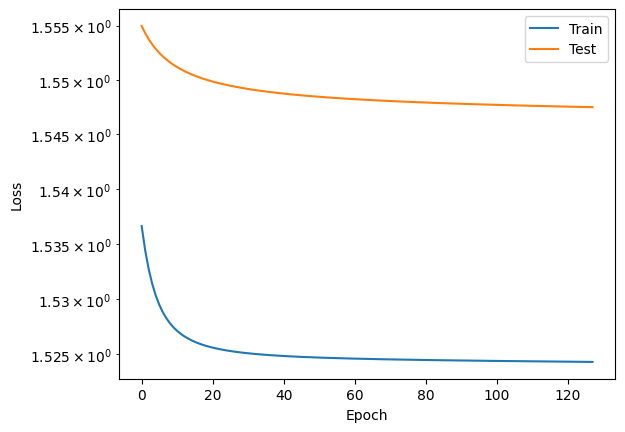

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

#### Question 8:

Vous devez observer que les deux fonctions de pertes décroissent pendant l'entraînement. Les hyperparamètres donnés sont loins d'être optimaux. Expérimentez différentes valeurs pour le learning rate, la taille du batch, et le nombre d'époques, et essayez d'interprétez vos observations.

Avec des bons hyperparamètres, vous devriez à la fin obtenir une perte avoisinant les 0.2 (train et test).

#### Question 9:

Enfin, vous pouvez évaluer la politique apprise par imitation au sein de l'environnement. 

La première cellule permet d'afficher les sortiez générées par votre modèle sur le dataset de test, en comparaison avec les données contenues dans le dataset. Ce graphique représente en abscisse les vraies actions enregistrées dans le dataset, et en ordonnées celles prédites par votre modèle. C'est normal que le modèle ne soit pas parfait, mais on doit quand même observer un corrélation positive.

La deuxième cellule sauvegarde votre modèle et lance le simulateur en utilisant votre modèle comme politique de l'agent. Si votre politique fonctionne bien, vous devriez observer un agent qui longe les murs. Si ce n'est pas le cas, il faut corriger votre entraînement du réseau de neurones.

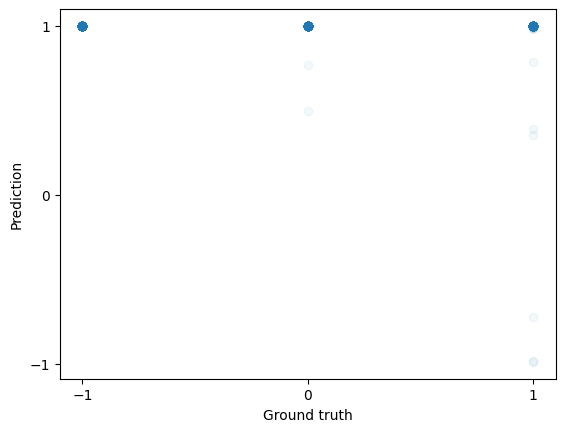

In [17]:
ground_truth = y_test
predictions = model.predict(x_test)

plt.scatter(ground_truth[:, 0], predictions[:, 0], alpha=0.05)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()

In [18]:
from env import ModelGUI, ExampleRoom

playground = ExampleRoom()
gui = ModelGUI(model, playground, playground.agent, draw_sensors=True)
gui.run()

2025-09-22 22:19:06.244 Python[63979:1254378] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/ng/j6l1mb4n0pdgrbv179zfppq80000gn/T/org.python.python.savedState


GLException: (0x500): Invalid enum. An unacceptable value is specified for an enumerated argument.

#### Pour aller plus loin

- Que se passe-t'il lorsque le learning rate est trop grand ou trop petit ?

| | + | - |
| --- | :---: | :---: |
| lr grand | convergence rapide | |
| lr petit | | minimum local plus précis |

- Que risque-t'il de se passer si le dataset d'entraînement est trop petit ? Essayez de réduire sa taille à 1000, 100, 10. Qu'est-ce que vous observez ?
    1. Overfitting
    2. No learning

- Essayez d'implémenter et tester d'autres fonctions d'activation.
- Le fichier generate_data.py est utilisé pour générer les données sur lesquelles vous vous êtes entraînés. Ce progamme vous fait générer à la main 10 trajectoires (contrôlées avec le clavier). Les trajectoires se terminent quand l'agent atteint la salle en bas à gauche. Essayez de générer un nouveau dataset suivant une politique différente (par exemple qui longe les murs de gauche). A noter que votre politique doit toujours avancer (le réseau de neurones ne prédit que la rotation). Il faudra éventuellement modifier le fichier pour qu'il sauvegarde les données dans un nouveau fichier sans écraser les autres. Entraînez ensuite votre modèle sur les nouvelles données, est-ce que vous arrivez toujours à imiter la politique que vous avez simulée ? N'oubliez pas que du point de vue de l'agent, seules les valeurs des capteurs de distance sont disponibles, et que le réseau ne peut apprendre que des politiques déterministes.